Title: Binary Morphology
Author: Thomas M. Breuel
Institution: UniKL

In [14]:

from scipy.ndimage import filters
def imrow(*args,**kw):
    size = kw.get("s",8)
    if "s" in kw: del kw["s"]
    n = len(args)
    gray()
    subplots(1,n,figsize=(n*size,size))
    for i,im in enumerate(args):
        subplot(1,n,i+1); imshow(im,**kw)

test = mean(imread("testimage.jpg")/255.0,axis=2)

# Binary Morphology

(mathematical morphology)

Another useful set of non-linear filters comes from *mathematical morphology*.
These filters are easiest to describe on binary images, so that's what we are starting with.

Generally, given an image containing shapes (identified by pixels with value 1), 
in binary mathematical morphology, we try to fit a second shape (the mask)
into that shape somehow.  This is illustrated by the following images denoting the four
basic operations of mathematical morphology: erosion, dilation, opening, and closing.

![Erosion](files/Figures/erosion.png)
![Dilation](files/Figures/dilation.png)
![Opening](files/Figures/opening.png)
![Closing](files/Figures/closing.png)

(images from Wikipedia)

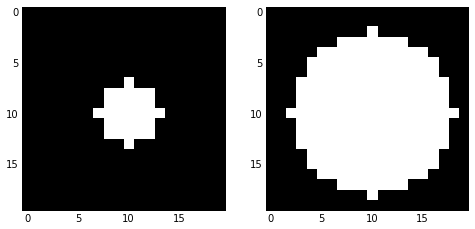

In [15]:
# circular structuring elements
from scipy.ndimage import morphology
xs,ys = meshgrid(range(20),range(20))
m3 = ((xs-10)**2+(ys-10)**2)<=9
m8 = ((xs-10)**2+(ys-10)**2)<=64
imrow(m3,m8,interpolation='nearest',s=4)

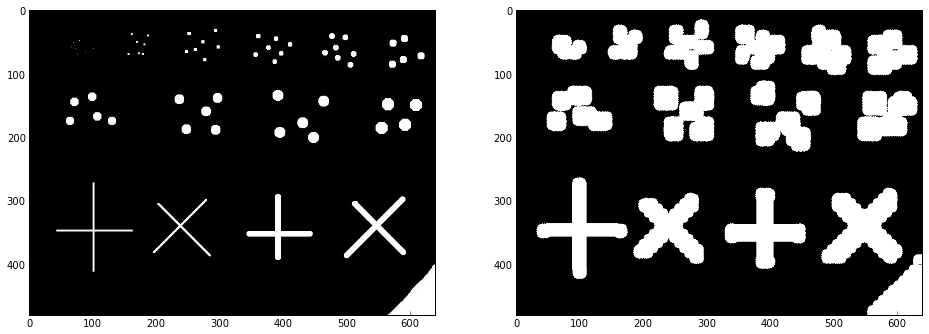

In [9]:
# morphologial dilation
imrow(test,morphology.binary_dilation(test,m8))

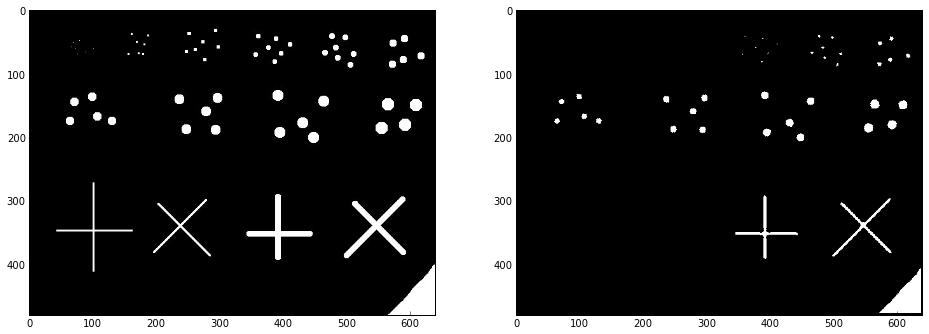

In [10]:
# morphological erosion
imrow(test,morphology.binary_erosion(test,m3))

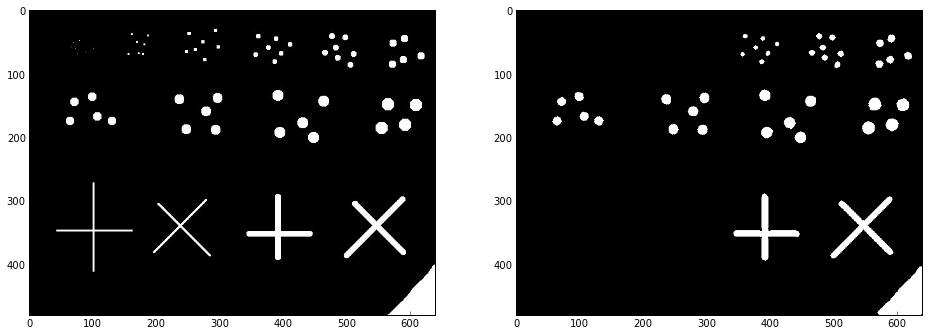

In [11]:
# morphological opening
imrow(test,morphology.binary_opening(test,m3))

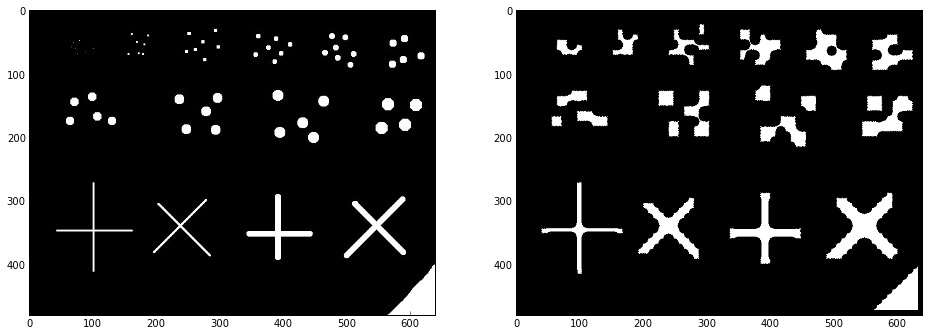

In [12]:
# morphological closing
imrow(test,morphology.binary_closing(test,m8))

(mathematical definitions)

Mathematically, these operations can be defined in terms of sets.
Let the pixels of the image be given by the set $A$
and those of the mask by the set $B$.

Denote by $B_z$ the set of translated points $B_z = \\{b+z | b\in B\\}$.

- Erosion: $A \ominus B = \\{z \in E | B_z \subseteq A \\}$
- Dilation: $A \oplus B = \\{z \in E | B_z \cap A \neq \oslash \\}$
- Opening: $A \circ B = (A \ominus B) \oplus B$
- Closing: $A \bullet B = (A \oplus B) \ominus B$

The set operations are as usual.  
We also need reflection of a set of points through the origin,
$\hat{B} = \\{-x | x\in B\\}$

(Python equivalents of other oprations)


Incidentally, remember how we can implement these binary operations on images:

- $I^c$ = `1-image`
- $\hat{I}$ = `I[::-1,::-1]`
- $B_z$ = `roll(roll(B,z[0],0),z[1],1)`
- $A\cap B$ = `minimum(A,B)`
- $A\cup B$ = `maximum(A,B)`

(minimum / maximum filter equivalents)

Erosion and dilation can also be thought of as _local minima_ and _local maxima_ filters over binary images, defined over a region determined by the mask $B$.

The minimum and maximum filters from the library effectively compute morphological operations over rectangles.

(mathematical properties)

There are also some mathematical properties these operations satisfy,
somewhat similar to what we found for linear filters (not exhaustive):

_translation invariance_ or _shift invariance_

duality:

$$A \oplus B = (A^c \ominus \hat{B})^c$$
$$A \bullet B = (A^c \circ \hat{B})^c$$

(properties of dilation)

commutativity: 

$$A \oplus B = B \oplus A$$

associativity: 

$$(A\oplus B)\oplus C = A\oplus (B\oplus C)$$

distributivity over set union: 

$$A\oplus (B\cup C) = A\oplus B \cup A \oplus C$$

(properties of erosion)

NB: these are not the same as dilation

alternative to associativity:

$(A\ominus B)\ominus C = A\ominus (B\oplus C)$

distributivity:

$$A \ominus (B \cup C) = A\ominus B \cup A \ominus C$$

(idempotency and monotonicity)


opening and closing are _idempotent_: 

$$(A \bullet B) \bullet B = A \bullet B$$

monotonicity properties:

$$(A \ominus B) \subseteq (A \circ B) \subseteq A \subseteq (A \bullet B) \subseteq (A \oplus B)$$

if origin is in $B$ and $B \subseteq C$ :

$$A \oplus B\subseteq A\oplus C$$ 

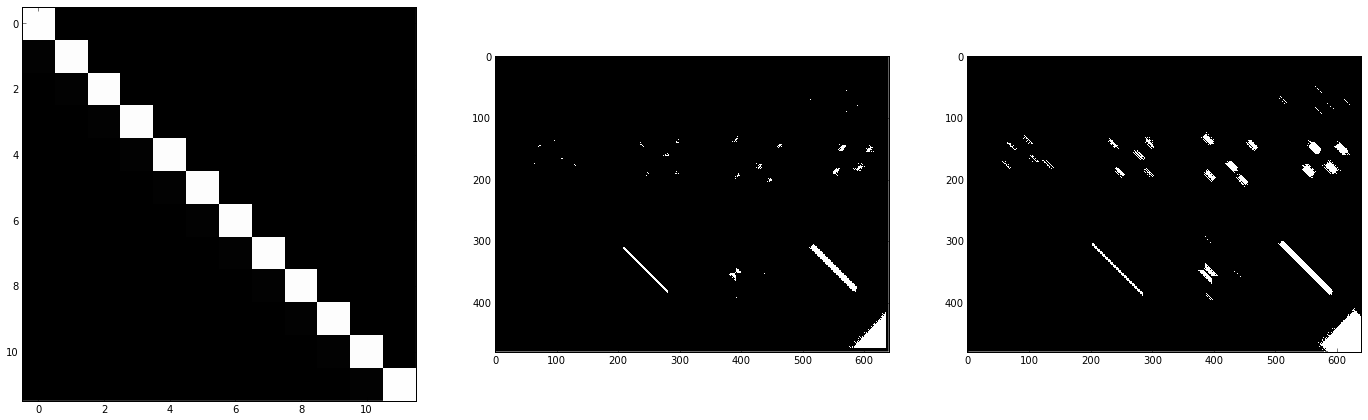

In [13]:
d = zeros((12,12))
for i in range(12): d[i,i] = 1
imrow(d,morphology.binary_erosion(test,d),morphology.binary_opening(test,d),interpolation='none')

As you can see, this kind of "detects patterns" in the image.

Hit or Miss Transform
=====================

There is a useful combination of these operations called the *hit or miss transform*.

$A \odot (B,C) = (A \ominus B) \cap (A^c \ominus C)$

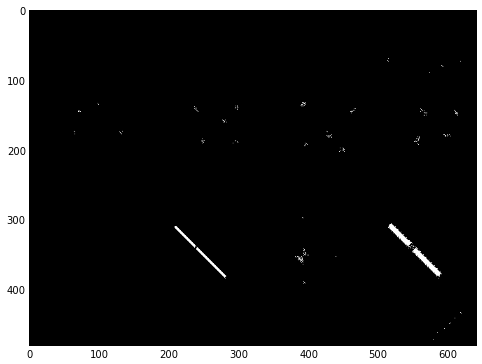

In [14]:
b = zeros((12,12))
for i in range(12): b[i,i] = 1  
c = zeros((12,12))
c[11,0] = 1
c[0,11] = 1
import numpy
imrow(bitwise_and(morphology.binary_erosion(test,b),morphology.binary_erosion(1-test,c)))

# Hit-or-Miss Example

Let's say we want to find the letter "I" in this image.



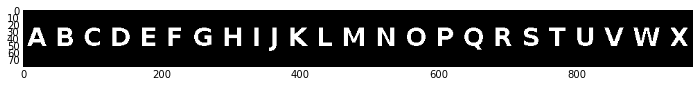

In [44]:
caps0 = 1*(mean(imread("caps.png"),2)<0.5)
gray(); figsize(12,6); imshow(caps0)

Usually, images are noisy and degraded. We can simulate that with this simple document image degradation model. Noise means that we can't do pixel accurate matching.



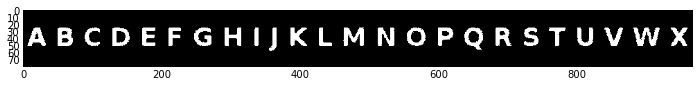

In [47]:
caps = 1-mean(imread("caps.png"),2)
caps -= amin(caps); caps /= amax(caps)
caps = filters.gaussian_filter(caps+0.0,1.0)
caps += 0.4*(rand(*caps.shape)-0.5)
caps = 1*(caps>0.5)
imshow(caps)

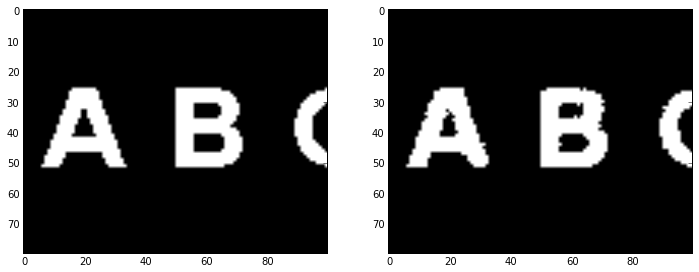

In [48]:
subplot(121); imshow(caps0[:,:100])
subplot(122); imshow(caps[:,:100])

Here is the template for the letter.


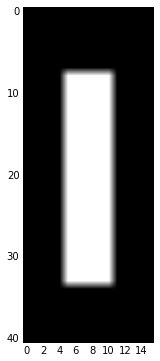

In [49]:
template = 1*(mean(imread("I.png"),2)<0.5)
gray(); imshow(template)

We require most of the pixels to be present. Since the edge of the character may be degraded, we are using a slightly smaller template to match the inside pixels. We obtain that template using mathematical morphology.



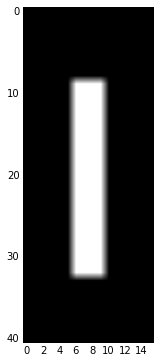

In [50]:
inner = morphology.binary_erosion(template,iterations=1)
imshow(inner)

When we match with this template, we get a large number of false matches and one true match.



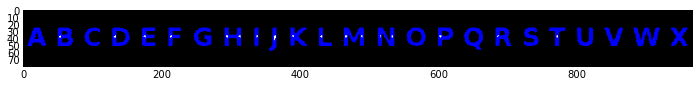

In [57]:
imatch = morphology.binary_erosion(caps,structure=inner)
imshow(transpose(array([imatch,imatch,caps]),[1,2,0]))

We need a second template that asserts that the outside of the character should not contain pixels. We also construct this using mathematical morphology.



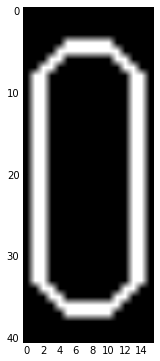

In [52]:
outer = maximum(0,morphology.binary_dilation(template,iterations=4)-morphology.binary_dilation(template,iterations=2))
imshow(outer)

We can visualize the relationship between the outer and the inner templates by combining them numerically.



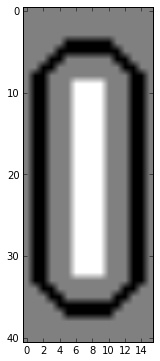

In [53]:
imshow(inner-outer)

We can now visualize the combination of the `imatch` and `omatch` locations.



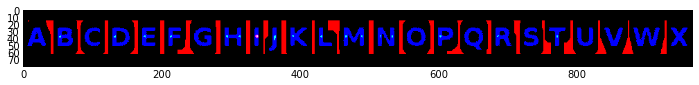

In [59]:
omatch = morphology.binary_erosion(1-caps,structure=outer)
imshow(transpose(array([omatch,imatch,caps]),[1,2,0]))

The actual match location is where both the inside and the outside match. This is the hit-or-miss transform.



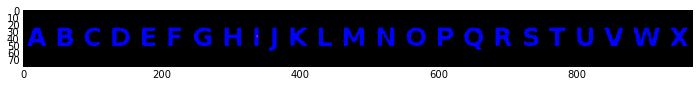

In [62]:
imshow(transpose(array([imatch*omatch,zeros(omatch.shape),caps]),[1,2,0]))